# Next-State Neural Networks
### 5/12/23

In [2]:
# for ESN implementation
!pip install reservoirpy

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Flatten

import numpy as np
from tensorflow import keras

from reservoirpy.nodes import Reservoir, Ridge, Input
from sklearn.metrics import mean_squared_error

In [4]:
# Define the parameters for the Lorenz system
time_steps = 1000
step_size = 10
dt = 0.01
num_epochs = 100

In [5]:
# Define the Lorenz system equations
def lorenz(x, y, z, sigma=10, rho=28, beta=8/3):
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return dx_dt, dy_dt, dz_dt

In [6]:
# Generate Initial Lorenz system data
x0 = np.random.uniform(-20, 20)
y0 = np.random.uniform(-20, 20)
z0 = np.random.uniform(0, 50)
init = np.zeros((time_steps, 3))
init[0, :] = [x0, y0, z0]


def gen_lorenz(x, rhos):
    X = []
    Y = []

    for rho in rhos:
        for i in range(1, time_steps):
            dx_dt, dy_dt, dz_dt = lorenz(x[i-1, 0], x[i-1, 1], x[i-1, 2], rho=rho)
            x[i, 0] = x[i-1, 0] + dx_dt * dt
            x[i, 1] = x[i-1, 1] + dy_dt * dt
            x[i, 2] = x[i-1, 2] + dz_dt * dt

        # Create the input and output data for the model
        X_rho = np.zeros((time_steps - 10, 10, 3))
        Y_rho = np.zeros((time_steps - 10, 3))
        for i in range(10, time_steps):
            X_rho[i-10,:,:] = x[i-10:i,:]
            Y_rho[i-10,:] = x[i,:]
        
        # Append the data for this rho value to the overall dataset
        X.append(X_rho)
        Y.append(Y_rho)

    # Combine the data for different rho values
    X = np.concatenate(X)
    Y = np.concatenate(Y)
    return X, Y

In [7]:
# Function to plot on rhos
def predict_on(x, rhos, net):
    figsize = (10,5)
    if (len(rhos) == 3):
        figsize=(20,5)

    # Create the figure for plotting the results
    fig, axs = plt.subplots(1, len(rhos), figsize=figsize, subplot_kw={'projection': '3d'})

    # Loop over different values of rho
    for j in range(len(rhos)):
        rho = rhos[j]
        for i in range(1, time_steps):
            dx_dt, dy_dt, dz_dt = lorenz(x[i-1, 0], x[i-1, 1], x[i-1, 2], rho=rho)
            x[i, 0] = x[i-1, 0] + dx_dt * dt
            x[i, 1] = x[i-1, 1] + dy_dt * dt
            x[i, 2] = x[i-1, 2] + dz_dt * dt

        # Create the input and output data for the model
        X = np.zeros((time_steps - 10, 10, 3))
        Y = np.zeros((time_steps - 10, 3))
        for i in range(10, time_steps):
            X[i-10,:,:] = x[i-10:i,:]
            Y[i-10,:] = x[i,:]

        # Make predictions on the testing set
        y_pred = net.predict(X, verbose=0)

        # Evaluate the model on the testing set
        mse = net.evaluate(X, Y, verbose=0)
        print("Mean squared error:", mse, "for rho = {}".format(rho))   
        
        # Plot the actual and predicted trajectories
        axs[j].plot(Y[:,0], Y[:,1], Y[:,2], label='Actual')
        axs[j].plot(y_pred[:,0], y_pred[:,1], y_pred[:,2], label='Predicted')
        axs[j].set_xlabel('X')
        axs[j].set_ylabel('Y')
        axs[j].set_zlabel('Z')
        axs[j].legend()
        axs[j].set_title('rho = {}'.format(rho))

    plt.show()


### Problem 1

In [8]:
# Define the FNN model
net_ff = Sequential()
net_ff.add(Flatten(input_shape=(10, 3)))
net_ff.add(Dense(32, activation='relu'))
net_ff.add(Dense(32, activation='relu'))
net_ff.add(Dense(3, activation=None))

net_ff.compile(optimizer='adam', loss='mse')

# Compile the model
net_ff.compile(loss='mse', optimizer='adam')

In [9]:
X, Y = gen_lorenz(init, [10, 28, 40])

# Split the data into training and testing sets
train_size = int(0.9 * len(X))
train_X, test_X = X[:train_size,:,:], X[train_size:,:,:]
train_Y, test_Y = Y[:train_size,:], Y[train_size:,:]

# Train the model
net_ff.fit(train_X, train_Y, epochs=num_epochs, batch_size=32, verbose=2)

# Evaluate the model on the testing set
mse = net_ff.evaluate(test_X, test_Y, verbose=0)
print("Mean squared error:", mse)

# Make predictions on the testing set
y_pred = net_ff.predict(test_X, verbose=0)

Epoch 1/100
84/84 - 1s - loss: 42.0250 - 529ms/epoch - 6ms/step
Epoch 2/100
84/84 - 0s - loss: 4.2466 - 43ms/epoch - 512us/step
Epoch 3/100
84/84 - 0s - loss: 2.0703 - 42ms/epoch - 500us/step
Epoch 4/100
84/84 - 0s - loss: 1.3220 - 43ms/epoch - 512us/step
Epoch 5/100
84/84 - 0s - loss: 0.8810 - 42ms/epoch - 496us/step
Epoch 6/100
84/84 - 0s - loss: 0.5186 - 42ms/epoch - 500us/step
Epoch 7/100
84/84 - 0s - loss: 0.3439 - 42ms/epoch - 500us/step
Epoch 8/100
84/84 - 0s - loss: 0.2601 - 42ms/epoch - 500us/step
Epoch 9/100
84/84 - 0s - loss: 0.2323 - 42ms/epoch - 500us/step
Epoch 10/100
84/84 - 0s - loss: 0.1921 - 42ms/epoch - 500us/step
Epoch 11/100
84/84 - 0s - loss: 0.1720 - 43ms/epoch - 512us/step
Epoch 12/100
84/84 - 0s - loss: 0.1640 - 42ms/epoch - 500us/step
Epoch 13/100
84/84 - 0s - loss: 0.1521 - 42ms/epoch - 500us/step
Epoch 14/100
84/84 - 0s - loss: 0.1455 - 41ms/epoch - 489us/step
Epoch 15/100
84/84 - 0s - loss: 0.1393 - 41ms/epoch - 489us/step
Epoch 16/100
84/84 - 0s - loss: 0.

Mean squared error: 0.0059122247621417046 for rho = 10
Mean squared error: 0.028158457949757576 for rho = 28
Mean squared error: 0.0655554011464119 for rho = 40


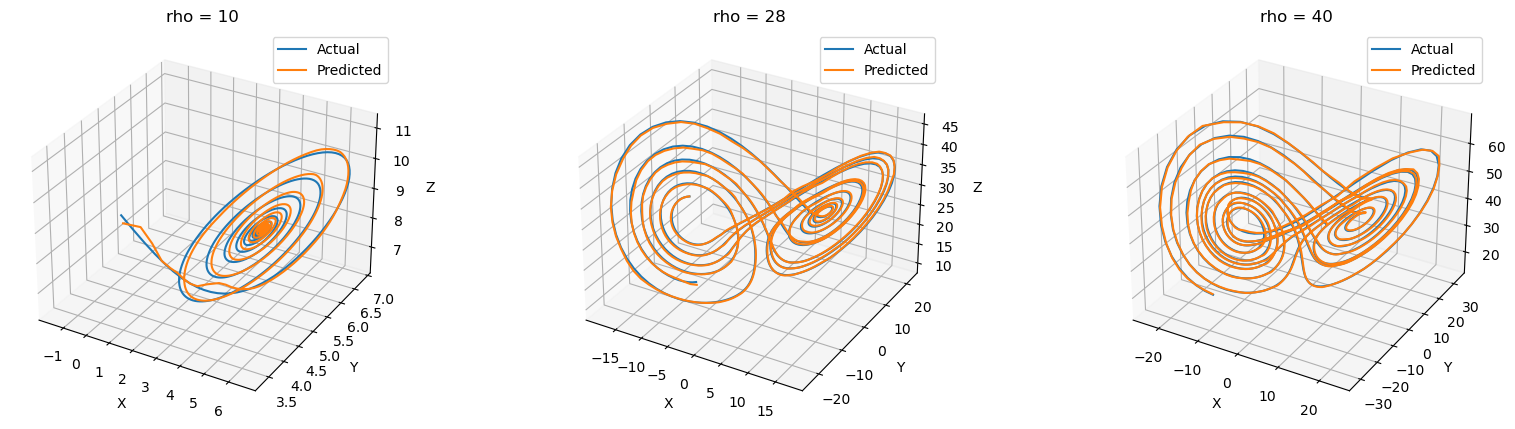

In [10]:
predict_on(init, [10,28,40], net_ff)

#### Predict rho = 17, 35

Mean squared error: 0.05537094175815582 for rho = 17
Mean squared error: 0.045406144112348557 for rho = 35


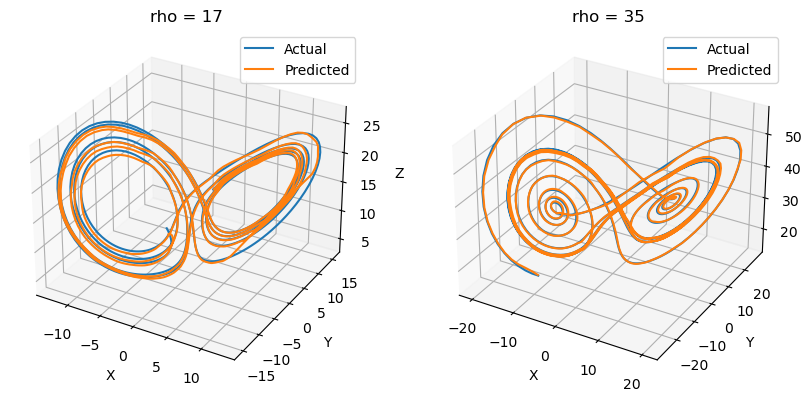

In [11]:
predict_on(init, [17, 35], net_ff)

### Problem 2

#### LSTM

In [12]:
# Define the LSTM model
net_lstm = Sequential()
net_lstm.add(LSTM(64, input_shape=(10, 3)))
net_lstm.add(Dense(3))

# Compile the model
net_lstm.compile(loss='mse', optimizer='adam')

In [13]:
# Train the model
net_lstm.fit(train_X, train_Y, epochs=num_epochs, batch_size=32, verbose=2)

# Evaluate the model on the testing set
mse = net_lstm.evaluate(test_X, test_Y, verbose=0)
print("Mean squared error:", mse)

# Make predictions on the testing set
y_pred = net_lstm.predict(test_X, verbose=0)

Epoch 1/100
84/84 - 2s - loss: 201.9676 - 2s/epoch - 20ms/step
Epoch 2/100
84/84 - 0s - loss: 111.5716 - 163ms/epoch - 2ms/step
Epoch 3/100
84/84 - 0s - loss: 75.0263 - 162ms/epoch - 2ms/step
Epoch 4/100
84/84 - 0s - loss: 54.0072 - 162ms/epoch - 2ms/step
Epoch 5/100
84/84 - 0s - loss: 40.6446 - 169ms/epoch - 2ms/step
Epoch 6/100
84/84 - 0s - loss: 31.4211 - 166ms/epoch - 2ms/step
Epoch 7/100
84/84 - 0s - loss: 24.7960 - 162ms/epoch - 2ms/step
Epoch 8/100
84/84 - 0s - loss: 20.0167 - 163ms/epoch - 2ms/step
Epoch 9/100
84/84 - 0s - loss: 16.4701 - 161ms/epoch - 2ms/step
Epoch 10/100
84/84 - 0s - loss: 13.7667 - 167ms/epoch - 2ms/step
Epoch 11/100
84/84 - 0s - loss: 11.6711 - 163ms/epoch - 2ms/step
Epoch 12/100
84/84 - 0s - loss: 10.0492 - 162ms/epoch - 2ms/step
Epoch 13/100
84/84 - 0s - loss: 8.7352 - 163ms/epoch - 2ms/step
Epoch 14/100
84/84 - 0s - loss: 7.6367 - 161ms/epoch - 2ms/step
Epoch 15/100
84/84 - 0s - loss: 6.7159 - 170ms/epoch - 2ms/step
Epoch 16/100
84/84 - 0s - loss: 5.963

Mean squared error: 0.0009619670454412699 for rho = 10
Mean squared error: 0.011930308304727077 for rho = 28
Mean squared error: 0.03743388503789902 for rho = 40


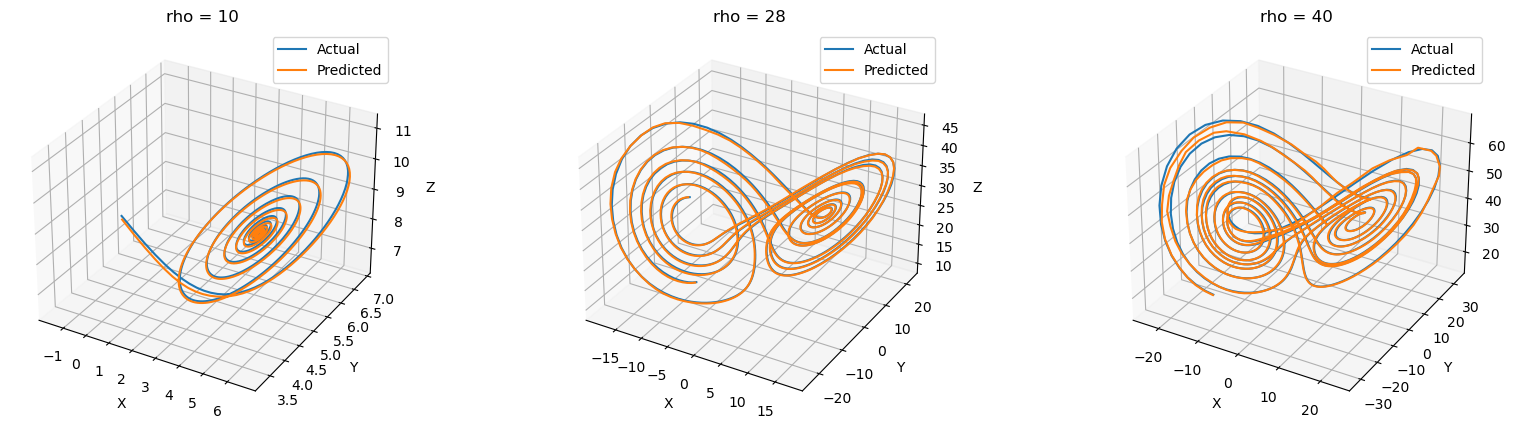

In [14]:
predict_on(init, [10, 28, 40], net_lstm)

Mean squared error: 0.050436992198228836 for rho = 17
Mean squared error: 0.03178843855857849 for rho = 35


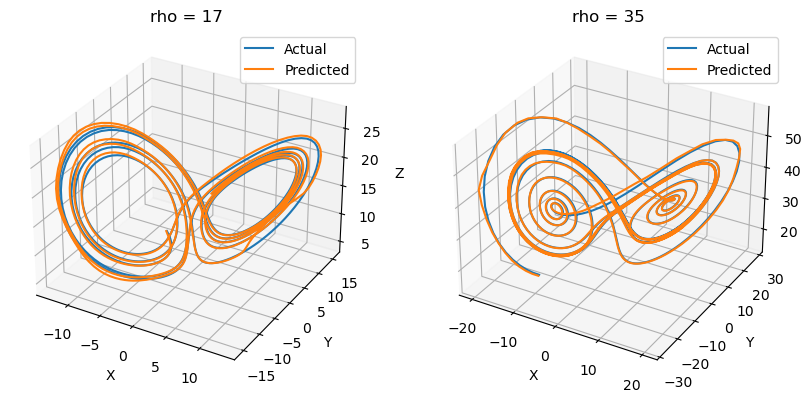

In [15]:
predict_on(init, [17, 35], net_lstm)

#### RN

In [16]:
# Define the model architecture
net_rnn = Sequential()
net_rnn.add(SimpleRNN(50, input_shape=(10, 3)))
net_rnn.add(Dense(3))

# Compile the model
net_rnn.compile(loss='mse', optimizer='adam')

In [17]:
rhos = [10, 28, 40]

In [18]:
# Train the model
net_rnn.fit(train_X, train_Y, epochs=num_epochs, batch_size=32, verbose=2)

# Evaluate the model on the testing set
mse = net_rnn.evaluate(test_X, test_Y, verbose=0)
print("Mean squared error:", mse)

# Make predictions on the testing set
y_pred = net_rnn.predict(test_X, verbose=0)

Epoch 1/100
84/84 - 1s - loss: 220.7189 - 810ms/epoch - 10ms/step
Epoch 2/100
84/84 - 0s - loss: 154.2753 - 76ms/epoch - 906us/step
Epoch 3/100
84/84 - 0s - loss: 120.8752 - 72ms/epoch - 859us/step
Epoch 4/100
84/84 - 0s - loss: 95.0876 - 74ms/epoch - 882us/step
Epoch 5/100
84/84 - 0s - loss: 75.0748 - 73ms/epoch - 870us/step
Epoch 6/100
84/84 - 0s - loss: 60.2182 - 72ms/epoch - 858us/step
Epoch 7/100
84/84 - 0s - loss: 49.0127 - 72ms/epoch - 858us/step
Epoch 8/100
84/84 - 0s - loss: 40.4247 - 74ms/epoch - 882us/step
Epoch 9/100
84/84 - 0s - loss: 33.7737 - 72ms/epoch - 858us/step
Epoch 10/100
84/84 - 0s - loss: 28.5686 - 73ms/epoch - 870us/step
Epoch 11/100
84/84 - 0s - loss: 24.3828 - 84ms/epoch - 1ms/step
Epoch 12/100
84/84 - 0s - loss: 21.0165 - 83ms/epoch - 989us/step
Epoch 13/100
84/84 - 0s - loss: 18.2663 - 77ms/epoch - 917us/step
Epoch 14/100
84/84 - 0s - loss: 15.9692 - 80ms/epoch - 953us/step
Epoch 15/100
84/84 - 0s - loss: 14.0301 - 73ms/epoch - 870us/step
Epoch 16/100
84/84

Mean squared error: 0.0005062147392891347 for rho = 10
Mean squared error: 0.013675092719495296 for rho = 28
Mean squared error: 0.07739883661270142 for rho = 40


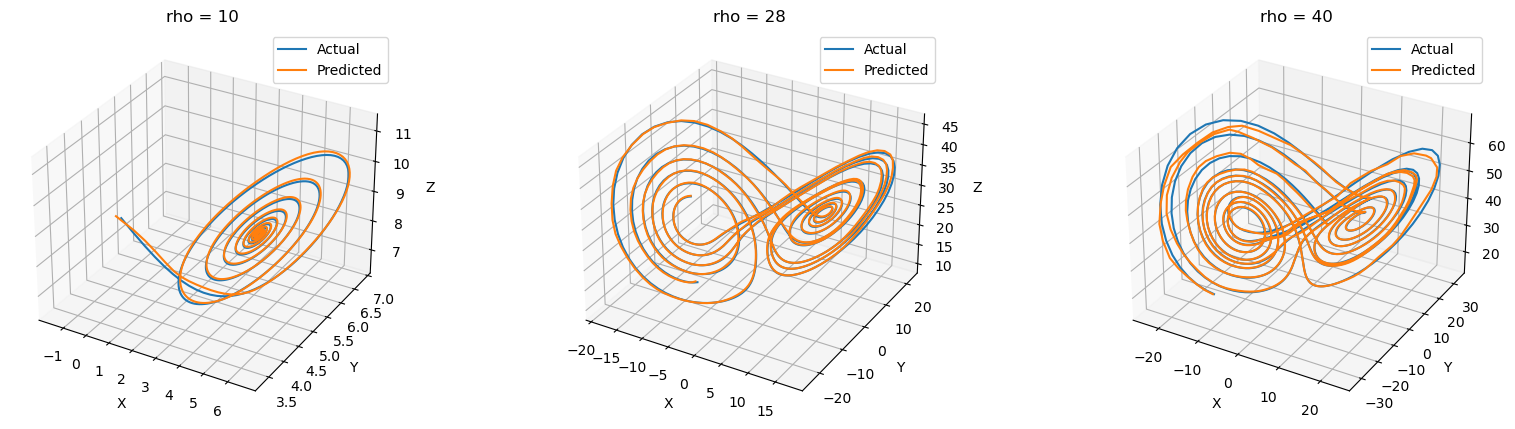

In [19]:
predict_on(init, [10, 28, 40], net_rnn)

Mean squared error: 0.07241684198379517 for rho = 17
Mean squared error: 0.02801322750747204 for rho = 35


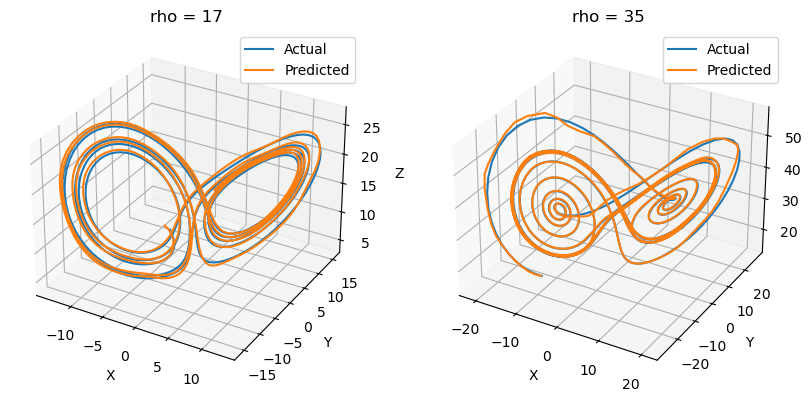

In [20]:
predict_on(init, [17, 35], net_rnn)

#### Echo State Networks

In [21]:
# Create the ESN model
data = Input(input_dim=3)
reservoir_node = Reservoir(units=100, size=100, leak_rate=.3, spectral_radius=.9)
readout_node = Ridge(output_dim=3, ridge=1e-2)

net_esn = data >> reservoir_node >> readout_node

In [22]:
rhos = [10, 28, 40]

In [24]:
for j in range(len(rhos)):
  rho = rhos[j]

  # Generate the training data
  np.random.seed(42)
  t = np.arange(0, time_steps, dt)
  x = np.zeros_like(t)
  y = np.zeros_like(t)
  z = np.zeros_like(t)
  x[0], y[0], z[0] = x0, y0, z0
  [x[0], y[0], z[0]] = init[0, :]  

  for i in range(1, time_steps):
      x_dot, y_dot, z_dot = lorenz(x[i-1], y[i-1], z[i-1], rho=rho)
      x[i] = x[i-1] + x_dot * dt
      y[i] = y[i-1] + y_dot * dt
      z[i] = z[i-1] + z_dot * dt

  # Split the data into input/output pairs
  input_data = np.column_stack([x, y, z])
  output_data = np.zeros_like(input_data)
  for i in range(len(t)):
      x_dot, y_dot, z_dot = lorenz(x[i], y[i], z[i], rho=rho)
      output_data[i, :] = [x_dot, y_dot, z_dot]

  # Split the data into training and testing sets
  train_size = int(0.9 * len(input_data))
  train_X, test_X = input_data[:train_size, :], input_data[train_size:, :]
  train_Y, test_Y = output_data[:train_size, :], output_data[train_size:, :]

  # Train the ESN
  net_esn.fit(train_X, train_Y)

  # Evaluate the ESN
  y_pred = net_esn.run(test_X)
  
  mse = mean_squared_error(test_Y, y_pred)
  print(f"Mean squared error: {mse}", "for rho = {}".format(rho))

Running Model-1: 90000it [00:11, 7534.93it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:11<00:00, 11.97s/it]


Fitting node Ridge-0...


Running Model-1: 10000it [00:01, 8303.30it/s]         


Mean squared error: 0.02733702962525365 for rho = 10


Running Model-1: 90000it [00:11, 7525.24it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:11<00:00, 11.99s/it]


Fitting node Ridge-0...


Running Model-1: 10000it [00:01, 8420.33it/s]         


Mean squared error: 1.5139517335993407 for rho = 28


Running Model-1: 90000it [00:11, 7524.89it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:11<00:00, 11.99s/it]


Fitting node Ridge-0...


Running Model-1: 10000it [00:01, 8416.93it/s]         

Mean squared error: 4.475234828698539 for rho = 40


In [25]:
rhos = [17, 35]

Running Model-1: 100000it [00:11, 8404.66it/s]        


Mean squared error: 2468.304189011738


Running Model-1: 100000it [00:11, 8450.72it/s]        


Mean squared error: 9098.272112835088


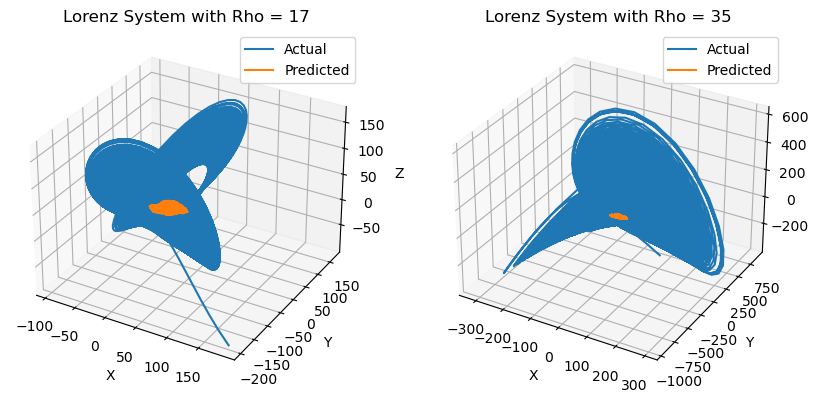

In [26]:
# Create the figure for plotting the results
fig, axs = plt.subplots(1, len(rhos), figsize=(10, 5), subplot_kw={'projection': '3d'})

for j in range(len(rhos)):
  rho = rhos[j]
  [x[0], y[0], z[0]] = init[0, :]

  for i in range(1, len(t)):
      x_dot, y_dot, z_dot = lorenz(x[i-1], y[i-1], z[i-1], rho=rho)
      x[i] = x[i-1] + x_dot * dt
      y[i] = y[i-1] + y_dot * dt
      z[i] = z[i-1] + z_dot * dt

  # Split the data into input/output pairs
  input_data = np.column_stack([x, y, z])
  output_data = np.zeros_like(input_data)
  for i in range(len(t)):
      x_dot, y_dot, z_dot = lorenz(x[i], y[i], z[i])
      output_data[i, :] = [x_dot, y_dot, z_dot]

  # Evaluate the ESN
  y_pred = net_esn.run(input_data)
  mse = mean_squared_error(output_data, y_pred)
  print(f"Mean squared error: {mse}")

  # Plot the actual and predicted trajectories
  axs[j].plot(output_data[:,0], output_data[:,1], output_data[:,2], label='Actual')
  axs[j].plot(y_pred[:,0], y_pred[:,1], y_pred[:,2], label='Predicted')
  axs[j].set_xlabel('X')
  axs[j].set_ylabel('Y')
  axs[j].set_zlabel('Z')
  axs[j].set_title(f'Lorenz System with Rho = {rho}')
  axs[j].legend()
plt.show()

Comparing MSE with `rho = 17`:
FNN: `0.05537094175815582`
LSTM: `0.050436992198228836`
RNN: `0.07241684198379517`
ESN: `2468.304189011738`

Comparing MSE with `rho = 35`:
FNN: `0.045406144112348557`
LSTM: `0.03178843855857849`
RNN: `0.02801322750747204`
ESN: `9098.272112835088`

For `rho = 17`, the LSTM performed best, with the FNN ranking second. For `rho = 35`, the RNN ranked best, with the LSTM second. The ESN struggled to predict on the model even though test results MSE were small. Overall, the FNN, LSTM, and RNN are preferable to the ESN as they have the smallest MSE for both predicted states of the Lorenz system, while the LSTM ranked well for both `rho = [17, 35]`.